# Tablet classifier

## Libs

In [ ]:
from sklearn.metrics import classification_report

from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.transforms.v2 import (
    Compose,
    CenterCrop,
    Normalize,
    ToTensor,
    Resize,
    GaussianBlur,
    RandomPhotometricDistort,
    RandomRotation,
)
from torchvision.transforms.functional import InterpolationMode

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

from torchsummary import summary

import math
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
from typing import List

## Data collection and preparation

### Load data

In [39]:
data_dir_name: str = "data_dir"
data_folder_name: str = "ogyeiv2"
train_data_folder_name: str = "train"
test_data_folder_name: str = "test"

project_dir_path: Path = Path(__name__).parent.resolve()
data_dir_path: Path = project_dir_path / Path(data_dir_name)
data_full_path: Path = data_dir_path / Path(data_folder_name)
train_data_path: str = str(data_full_path / Path(train_data_folder_name))
test_data_path: str = str(data_full_path / Path(test_data_folder_name)) 

print("Project dir path:            ", str(project_dir_path))
print("Data dir path:               ", str(data_dir_path))
print("Full path to data's folder:  ", str(data_full_path))
print("Train's data path to folder: ", train_data_path)
print("Test's data path to folder:  ", test_data_path)

Project dir path:             /Users/satanislav/Documents/tablet-classifier
Data dir path:                /Users/satanislav/Documents/tablet-classifier/data_dir
Full path to data's folder:   /Users/satanislav/Documents/tablet-classifier/data_dir/ogyeiv2
Train's data path to folder:  /Users/satanislav/Documents/tablet-classifier/data_dir/ogyeiv2/train
Test's data path to folder:   /Users/satanislav/Documents/tablet-classifier/data_dir/ogyeiv2/test


In [3]:
train_data = ImageFolder(train_data_path)
test_raw_data = ImageFolder(test_data_path)

### Preprocessing data

In [40]:
model_weights = EfficientNet_B1_Weights.IMAGENET1K_V1

train_transforms = Compose(
    [
        RandomPhotometricDistort(p=0.5, contrast=[0.8, 1.2], hue=[-0.1, 0.1]),
        GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        RandomRotation([-5, 5], fill=255.0),
        Resize(256, interpolation=InterpolationMode.BICUBIC),
        CenterCrop(240),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_test_transforms = model_weights.transforms()

/Users/satanislav/Documents/tablet-classifier/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [41]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transforms):
        super(TransformDataset, self).__init__()
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return self.transforms(x), y

In [42]:
def print_classes_names(train_data_path: str, test_data_path: str) -> None:
    train_classes_names: List[str] = [
        str(dir_name.name)
        for dir_name in Path(train_data_path).iterdir()
        if dir_name.is_dir()
    ]
    test_classes_names: List[str] = [
        str(dir_name.name)
        for dir_name in Path(test_data_path).iterdir()
        if dir_name.is_dir()
    ]

    classes_names: List[str] = list(set(train_classes_names) | set(test_classes_names))

    if len(set(classes_names)) == sum(
        1 for dir in Path(train_data_path).iterdir() if dir.is_dir()
    ):
        for index, class_name in enumerate(classes_names):
            print(f"{index}.  {class_name}")
    else:
        print("Wrong classes number")


def first_image_in_dir(class_dir: Path):
    files = sorted([p for p in class_dir.iterdir() if p.is_file()])
    return files[0] if files else None


def plot_classes(data_folder_path: str, num_cols: int, data_name: str) -> None:
    class_dirs = sorted([d for d in Path(data_folder_path).iterdir() if d.is_dir()])

    images_name_and_path = [(d.name, first_image_in_dir(d)) for d in class_dirs]
    num_rows: int = math.ceil(len(images_name_and_path) / num_cols)

    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=(num_cols * 2.2, num_rows * 2.2)
    )
    axes = axes.ravel()

    fig.suptitle(data_name.upper(), fontsize=14, y=1.02)

    for ax in axes:
        ax.axis("off")

    for i, (img_name, img_path) in enumerate(images_name_and_path):
        ax = axes[i]
        ax.set_title(img_name, fontsize=9, pad=4)

        if img_path is None:
            ax.text(0.5, 0.5, "no image", ha="center", va="center", fontsize=10)
            continue

        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

In [43]:
train_raw_data, valid_raw_data = random_split(train_data, [0.8, 0.2])

In [44]:
train_dataset = TransformDataset(train_raw_data, train_transforms)
val_dataset = TransformDataset(valid_raw_data, val_test_transforms)
test_dataset = TransformDataset(test_raw_data, val_test_transforms)

In [46]:
batch_size: int = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
    )

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
    )

In [10]:
print("Num classes in train and val data: ", sum(1 for dir in Path(train_data_path).iterdir()
                                                 if dir.is_dir()))
print("Num classes in test data:          ", sum(1 for dir in Path(test_data_path).iterdir()
                                                 if dir.is_dir()))
print()
print("Num images in train dataloader:    ", len(train_dataset))
print("Num images in val dataloader:      ", len(val_dataset))
print("Num images in test dataloader:     ", len(test_dataset))
print()
print("Num batchs in train dataloader:    ", len(train_dataloader))
print("Num batchs in val dataloader:      ", len(val_dataloader))
print("Num batchs in test dataloader:     ", len(test_dataloader))

Num classes in train and val data:  84
Num classes in test data:           84

Num images in train dataloader:     1882
Num images in val dataloader:       470
Num images in test dataloader:      504

Num batchs in train dataloader:     59
Num batchs in val dataloader:       15
Num batchs in test dataloader:      16


In [11]:
print_classes_names(train_data_path, test_data_path)

0.  strepsils
1.  xeter_20_mg
2.  ocutein
3.  cataflam_dolo_25_mg
4.  algopyrin_500_mg
5.  apranax_550_mg
6.  aspirin_ultra_500_mg
7.  vita_c
8.  tritace_hct_5_mg_25_mg
9.  semicillin_500_mg
10.  bila_git
11.  concor_10_mg
12.  kalium_r
13.  betaloc_50_mg
14.  ibumax_400_mg
15.  cetirizin_10_mg
16.  quamatel_40_mg
17.  tritace_5_mg
18.  teva_enterobene_2_mg
19.  urotrin
20.  dulsevia_60_mg
21.  novo_c_plus
22.  tricovel_tricoage45
23.  ambroxol_egis_30_mg
24.  jutavit_cink
25.  jutavit_c_vitamin
26.  milgamma
27.  theospirex_150_mg
28.  atoris_20_mg
29.  dorithricin_mentol
30.  meridian
31.  milurit_300_mg
32.  urzinol
33.  kalcium_magnezium_cink
34.  advil_ultra_forte
35.  letrox_50_mikrogramm
36.  algoflex_forte_dolo_400_mg
37.  nebivolol_sandoz_5_mg
38.  olicard_60_mg
39.  teva_ambrobene_30_mg
40.  coldrex
41.  controloc_20_mg
42.  valeriana_teva
43.  akineton_2_mg
44.  rubophen_500_mg
45.  diclopram_75-mg_20-mg
46.  metothyrin_10_mg
47.  acc_long_600_mg
48.  atorvastatin_teva_20_mg

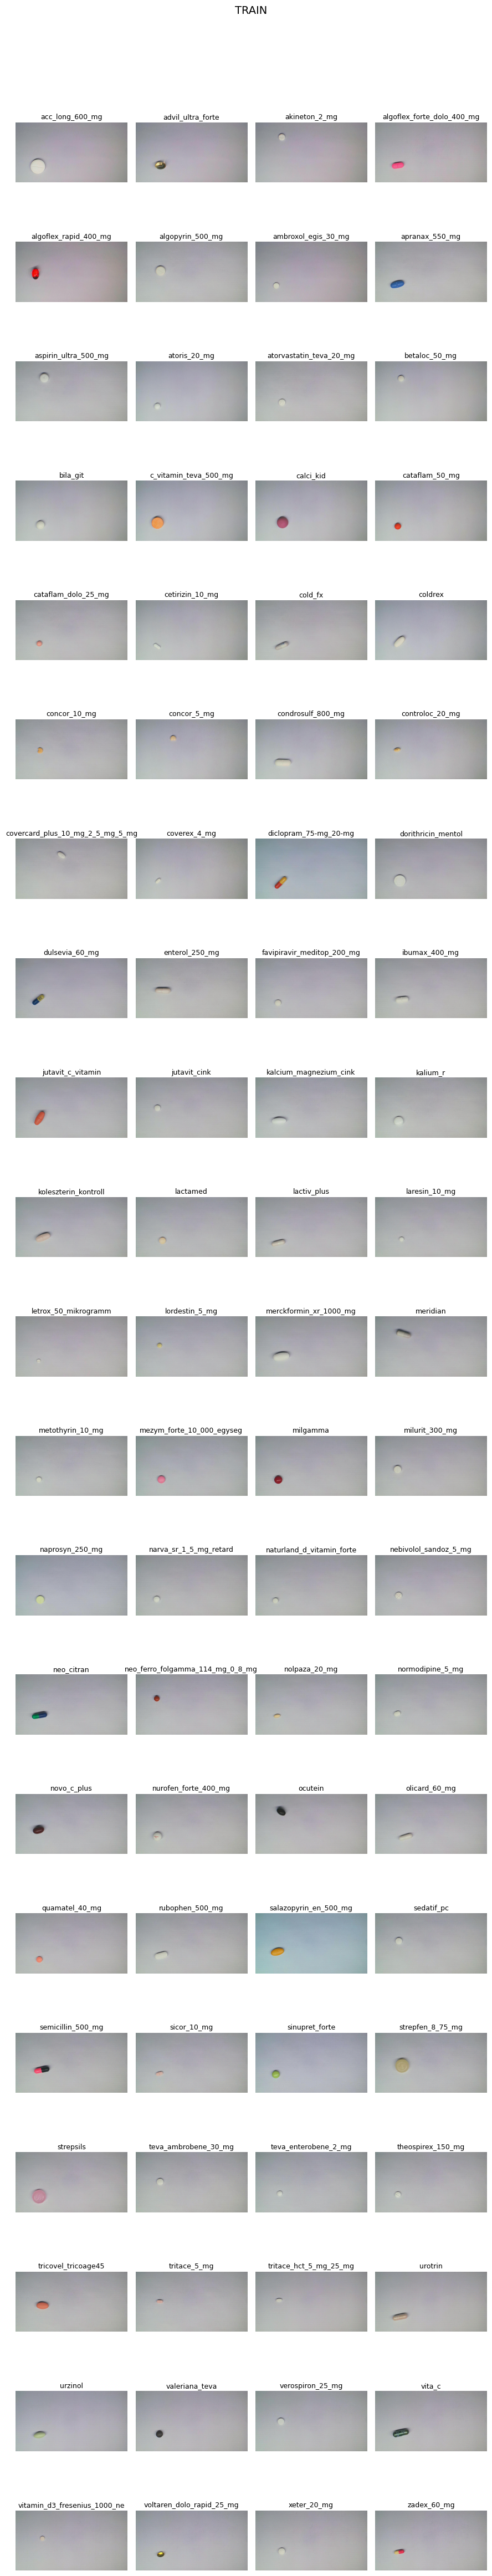

In [12]:
plot_classes(train_data_path, num_cols=4, data_name="TRAIN")

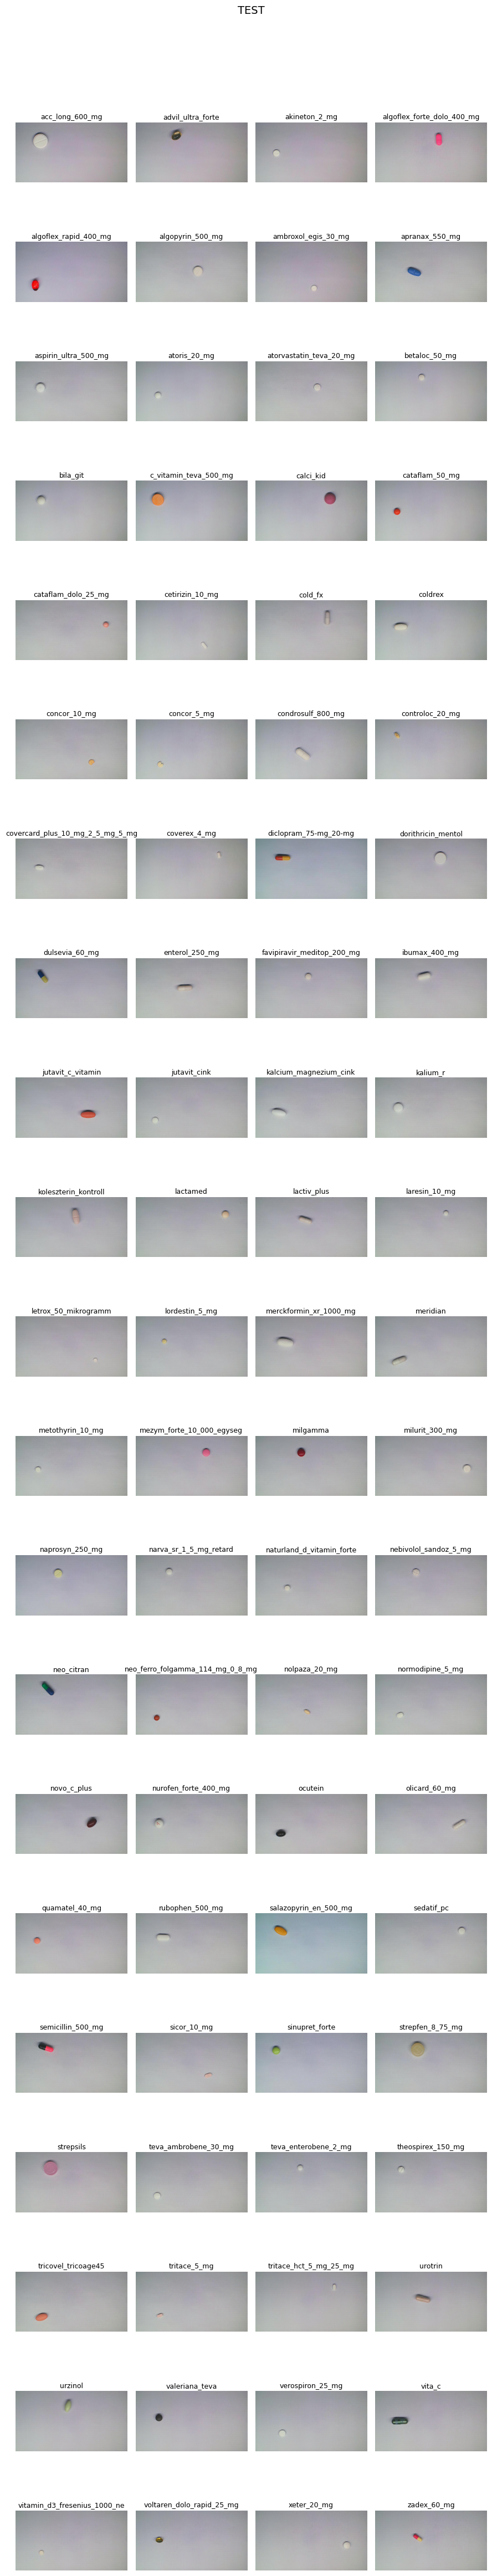

In [13]:
plot_classes(test_data_path, num_cols=4, data_name="TEST")

In [14]:
del print_classes_names, plot_classes

In [15]:
del train_dataset, val_dataset, test_dataset, batch_size

## Model

### Make model

In [16]:
weights = EfficientNet_B1_Weights.IMAGENET1K_V1
print(weights.transforms())

ImageClassification(
    crop_size=[240]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [17]:
model = efficientnet_b1(weights=weights)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [18]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [19]:
in_features = model.classifier[1].in_features
new_classif_layer = nn.Linear(in_features=in_features, out_features=84, bias=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = new_classif_layer

for param in model.classifier.parameters():
    param.requires_grad = True 

###  Train model

In [20]:
def plot_metrics(metrics_history) -> None:
    epochs = range(1, len(metrics_history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(epochs, metrics_history["train_loss"], label="Train loss")
    axes[0].plot(epochs, metrics_history["val_loss"], label="Val loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Train vs Val loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(
        epochs,
        metrics_history["train_acc"],
        marker="o",
        label="Train accuracy",
    )
    axes[1].plot(
        epochs,
        metrics_history["val_acc"],
        marker="x",
        label="Val accuracy",
    )
    axes[1].set_title("Train vs Val accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [21]:
def train_one_epoch(
    epoch_index,
    train_loader,
    optimizer,
    criterion,
    model,
    device,
):
    model.train()

    loss_sum = 0.0
    n_samples = 0
    correct_sum = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        loss_sum += loss.item() * bs
        n_samples += bs

        preds = torch.argmax(outputs, dim=1)
        correct_sum += (preds == labels).sum().item()

    avg_loss = loss_sum / max(1, n_samples)
    train_acc = correct_sum / max(1, n_samples)
    return avg_loss, train_acc


def train_model(
    epochs,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    model,
    device,
    model_dir_path,
):
    model.to(device)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    best_vloss = float("inf")

    for epoch in range(epochs):
        model_path: Path = model_dir_path / Path(f"meds_classifier_{epoch}.pt")
        print("--" * 15 + f" EPOOCH: {epoch + 1} end" + "--" * 15)

        avg_train_loss, train_acc = train_one_epoch(
            epoch, train_loader, optimizer, criterion, model, device
        )

        model.eval()

        val_loss_sum = 0.0
        val_correct_sum = 0
        val_samples_sum = 0

        with torch.no_grad():
            for vdata in val_loader:
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device, non_blocking=True)
                vlabels = vlabels.to(device, non_blocking=True)

                val_samples_sum += vlabels.size(0)

                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)

                val_loss_sum += vloss.item() * vlabels.size(0)

                vpreds = torch.argmax(voutputs, dim=1)
                val_correct_sum += (vpreds == vlabels).sum().item()

        avg_vloss = val_loss_sum / max(1, val_samples_sum)
        val_acc = val_correct_sum / max(1, val_samples_sum)

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(avg_vloss)
        history["val_acc"].append(val_acc)

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), model_path)

        print(f"TRAIN LOSS={avg_train_loss:.4f}, VAL LOSS={avg_vloss:.4f}")
        print(f"TRAIN ACC={train_acc:.4f}, VAL ACC={val_acc:.4f}")
        print("-" * 60)
        print()
    model.to("cpu")
    return history

In [22]:
model_dir_name: str = "model_dir"
model_dir_path: Path = project_dir_path/ Path(model_dir_name)

EPOCHS = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
%%time
metrics_history = train_model(
                            EPOCHS,
                            train_dataloader,
                            val_dataloader,
                            optimizer,
                            criterion,
                            model,
                            device,
                            model_dir_path,
                        )

------------------------------ EPOOCH: 1 end------------------------------
TRAIN LOSS=4.2266, VAL LOSS=3.5487
TRAIN ACC=0.0781, VAL ACC=0.3298
------------------------------------------------------------

------------------------------ EPOOCH: 2 end------------------------------
TRAIN LOSS=3.5275, VAL LOSS=2.9107
TRAIN ACC=0.2519, VAL ACC=0.4979
------------------------------------------------------------

------------------------------ EPOOCH: 3 end------------------------------
TRAIN LOSS=3.0889, VAL LOSS=2.4677
TRAIN ACC=0.3565, VAL ACC=0.5298
------------------------------------------------------------

------------------------------ EPOOCH: 4 end------------------------------
TRAIN LOSS=2.7738, VAL LOSS=2.1489
TRAIN ACC=0.4288, VAL ACC=0.5830
------------------------------------------------------------

------------------------------ EPOOCH: 5 end------------------------------
TRAIN LOSS=2.5347, VAL LOSS=1.8779
TRAIN ACC=0.4724, VAL ACC=0.6702
-------------------------------------

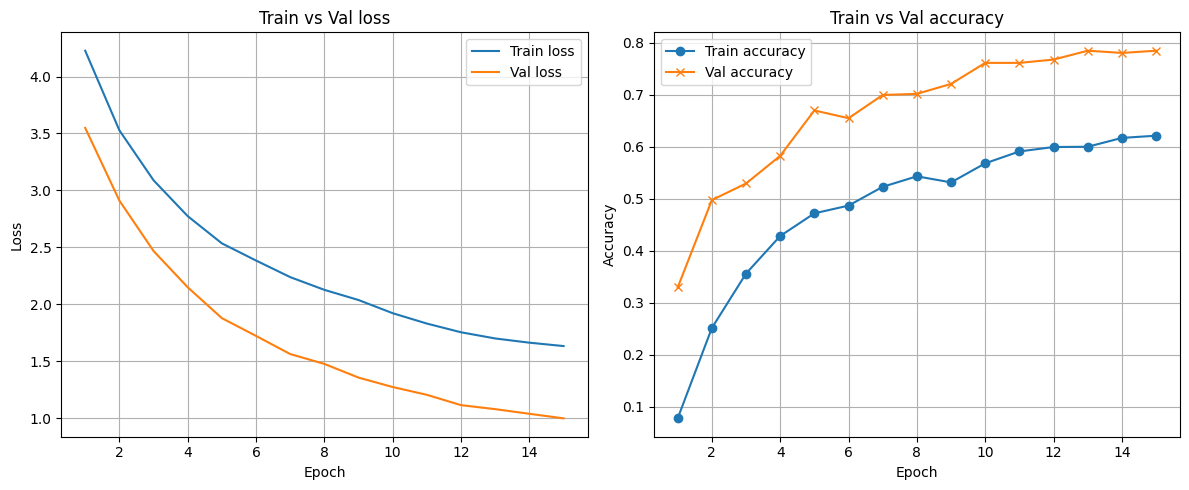

In [25]:
plot_metrics(metrics_history)

In [26]:
del train_model, optimizer, criterion, model, train_dataloader, val_dataloader

### Test Model

In [37]:
def test_model(model, test_dataloader, classes_names, device) -> None:
    labels_predicted = []
    labels_true = []

    model.eval()

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            labels_predicted.extend(predicted.cpu().numpy())
            labels_true.extend(labels.cpu().numpy())

    print(
        classification_report(labels_true, labels_predicted, target_names=classes_names)
    )


In [35]:
classes_names: List[str] = [str(dir.name) for dir in Path(train_data_path).iterdir() if dir.is_dir()]

model_name: str = "meds_classifier_14.pt"
model_path: str = str(model_dir_path / Path(model_name))


model = efficientnet_b1(weights=None)
model.classifier[1] = new_classif_layer
model.load_state_dict(torch.load(model_path, map_location=device))



<All keys matched successfully>

In [29]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [47]:
test_model(model, test_dataloader, classes_names, device)

                                  precision    recall  f1-score   support

                       calci_kid       1.00      1.00      1.00         6
             tricovel_tricoage45       0.86      1.00      0.92         6
                 cetirizin_10_mg       1.00      0.67      0.80         6
                         ocutein       1.00      1.00      1.00         6
                     xeter_20_mg       1.00      0.83      0.91         6
              dorithricin_mentol       0.83      0.83      0.83         6
                     lactiv_plus       0.67      1.00      0.80         6
                  enterol_250_mg       1.00      0.83      0.91         6
                  quamatel_40_mg       0.83      0.83      0.83         6
covercard_plus_10_mg_2_5_mg_5_mg       0.80      0.67      0.73         6
                   olicard_60_mg       0.67      1.00      0.80         6
            teva_ambrobene_30_mg       0.67      1.00      0.80         6
            letrox_50_mikrogramm     

In [31]:
del test_dataloader, test_model, model, classes_names

## Conclusion

- In which 5 classes does the model make mistakes most often?

	Most errors (by recall):

    1. **jutavit_c_vitamin** — recall 0.33 → about 4 errors out of 6 (a lot of FN)
    2. **betaloc_50_mg** — recall 0.50 → about 3 errors out of 6
    3. **cetirizin_10_mg** — recall 0.67 → about 2 errors out of 6
    4. **covercard_plus_10_mg_2_5_mg_5_mg** — recall 0.67 → about 2 errors out of 6
    5. **enterol_250_mg / xeter_20_mg / letrox_50_mikrogramm / vitamin_d3_fresenius_1000_ne / nurofen_forte_400_mg / narva_sr_1_5_mg_retard / advil_ultra_forte / acc_long_600_mg** — they have recall 0.83 → about 1 error out of 6



- Why can the model make mistakes in these classes?

    1. **Several classes have a similar shape/color/size** - The model confuses the “twins".
    2. **The inscriptions/engraving are small, and the input is 224×224 + blur/noise/rotation** - the model loses key details.
    3. **Intra-class variability: the different angles/highlights/shadows of one class are stronger than the differences between classes.**
    4. **Strong photometric augmentation can “recolor” the tablet and degrade grades where color is a key feature.**
    5. **There are few test cases per class (6)** - the metric “jumps”: one mistake greatly changes recall.

- In which classes does the model not make mistakes?

    1. **calci_kid**
    2. **ocutein**
    3. **sinupret_forte**
    4. **laresin_10_mg**

- Why are these classes recognized correctly?

    1. **Characteristic color/coating, very different from the others,**
    2. **Unique shape (oval/capsule/risk/thickness),**
    3. **Easy-to-read labeling,**
    4. **There is less variation in lighting/angle within the classroom.**

- How can the accuracy of the classifier be improved

    1. **Lower the LR (usually 0.001/0.0003 for Adam on the head) and add a scheduler.**
    2. **Fine-tuning backbone: unfreeze the top blocks of EfficientNet and teach with a small lr.**
    3. **Increase the input resolution (if labels are important): 224 - 256/300 (or model B1/B2/B3).**
    4. **Weaken “dangerous” augmentation if color is important (reduce hue/contrast, blur/noise less often).**
    5. **Label smoothing (for example 0.05–0.1) or AdamW + weight_decay — often gives a + to generalization.**

- How else can the results and model errors be analyzed?

    1. **Confusion matrix (top pairs of “class A gets confused with B”)** — will immediately show the “twins".
    2. **View top mistakes: save pictures where the model is confident but made a mistake (high confidence mistakes).**
    3. **Top-k accuracy (top-3 / top-5)** — useful for quality control/tips to the operator.
    4. **Grad-CAM: whether the model is looking at the tablet or at the background/glare.**
    5. **Embedding analysis (t-SNE/UMAP for the penultimate layer)** — it is clear which classes are mixed.
    6. **Data validation: Duplicates, mixed labels, different backgrounds/parties are often the source of “strange” classes.**